In [2]:
import argparse
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from utils.GNN_data import *
from utils.GNN_model import GIN
from utils.train_model import train_model
from utils.evaluate_model import *

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--batch_num', type=int, default=64, help='batch size') 
parser.add_argument('--epoch_num', type=int, default=200, help='Epoch number') 
parser.add_argument('--cover_interval', type=int, default=20, help='Cover interval')
parser.add_argument('--overlap', type=float, default=0.3, help='cover overlap')
parser.add_argument('--save_model_dir', type=str, default='./examples/saved_GNN_model', help='saved GNN model directory')
args = parser.parse_args([])

In [4]:
from torch_geometric.data import Data
import torch 
def load_inp_data(file_path, label):
    nodes, edges = [], []
    
    with open(file_path, 'r') as file:
        lines = file.readlines()

        node_section = False
        element_section = False

        for line in lines:
            line = line.strip()

            if "*Node" in line:
                node_section = True
                element_section = False
                continue

            if "*Element" in line:
                node_section = False
                element_section = True
                continue

            # Skip invalid lines like "*Nset" or "*Elset"
            if "*Nset" in line or "*Elset" in line:
                node_section = False
                element_section = False
                continue

            if node_section:
                parts = line.split(',')
                if len(parts) >= 3:
                    try:
                        x, y = float(parts[1].strip()), float(parts[2].strip())
                        nodes.append([x, y])
                    except ValueError:
                        continue

            if element_section:
                parts = line.split(',')
                if len(parts) >= 3 and parts[0].strip().isdigit() and parts[1].strip().isdigit() and parts[2].strip().isdigit():
                    start, end = int(parts[1].strip()) - 1, int(parts[2].strip()) - 1  # Convert 1-indexed to 0-indexed
                    
                    if start == end:
                        continue
                    
                    # Ensure indices are within valid range
                    if start < len(nodes) and end < len(nodes):
                        edges.append([start, end])
                    else:
                        print(f"Skipping invalid edge ({start+1}, {end+1}) in {file_path}")

    node_tensor = torch.tensor(nodes, dtype=torch.float)
    edge_tensor = torch.tensor(edges, dtype=torch.long).t().contiguous() if edges else torch.empty((2, 0), dtype=torch.long)

    data = Data(x=node_tensor, edge_index=edge_tensor, K=np.float64(label * 200000.00))
    return data

# Data loading

In [5]:
import os
from glob import glob

folder_list = ['Kagome', 'Hexagonal', 'Demi-A', 'Demi-B', 'Demi-C']
base_path = '.'  # or wherever your dataset folders are

dataset = []

for folder in folder_list:
    results_path = os.path.join(base_path, folder, 'Results.txt')
    inp_folder = os.path.join(base_path, folder, 'inp_files')

    # Parse Results.txt in the current folder
    file_labels = {}
    with open(results_path, 'r') as file:
        for line in file:
            if line.strip() == "" or "E/Es" in line:
                continue
            try:
                file_name, label = line.strip().split(', ')
                filename = file_name.strip().split('.')[0]
                label = float(label)
                file_labels[filename] = label
            except ValueError:
                print(f"[{folder}] Skipping invalid line: {line.strip()}")

    # Load each corresponding .inp file
    for file, label in file_labels.items():
        file_path = os.path.join(inp_folder, f"{file}.inp")
        if os.path.exists(file_path):
            data = load_inp_data(file_path, label)
            if data is not None:
                dataset.append(data)
        else:
            print(f"[{folder}] Missing file: {file_path}")

In [6]:
dataset

[Data(x=[104, 2], edge_index=[2, 180], K=3334.25610352),
 Data(x=[104, 2], edge_index=[2, 180], K=3319.36621094),
 Data(x=[104, 2], edge_index=[2, 180], K=3317.578125),
 Data(x=[104, 2], edge_index=[2, 180], K=3311.75683594),
 Data(x=[104, 2], edge_index=[2, 180], K=3309.0815429599998),
 Data(x=[104, 2], edge_index=[2, 180], K=3302.2961425800004),
 Data(x=[104, 2], edge_index=[2, 180], K=3319.8339843800004),
 Data(x=[104, 2], edge_index=[2, 180], K=3320.16333008),
 Data(x=[104, 2], edge_index=[2, 180], K=3303.1911621),
 Data(x=[104, 2], edge_index=[2, 180], K=3309.5705566399997),
 Data(x=[104, 2], edge_index=[2, 180], K=3318.5014648399997),
 Data(x=[104, 2], edge_index=[2, 180], K=3328.02441406),
 Data(x=[104, 2], edge_index=[2, 180], K=3314.78710938),
 Data(x=[104, 2], edge_index=[2, 180], K=3312.81298828),
 Data(x=[104, 2], edge_index=[2, 180], K=3311.1208496),
 Data(x=[104, 2], edge_index=[2, 180], K=3318.1435546800003),
 Data(x=[104, 2], edge_index=[2, 180], K=3292.6213379),
 Data(

In [7]:
dataset = feature_engineering(dataset)

In [8]:
batch_size = args.batch_num
epoch_num = args.epoch_num 
learning_rate = 0.001
overlap=args.overlap

# Check if the graph data is directed or undirected. For this study, undirected edges are used.
all_undirected_before = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (before conversion): {all_undirected_before}')  # True if all are undirected, False otherwise

# Convert all graphs in the dataset to undirected
dataset = [make_undirected(data) for data in dataset]

# Re-check if all graphs are now undirected
all_undirected_after = all(is_undirected(data) for data in dataset)
print(f'Graphs are undirected (after conversion): {all_undirected_after}')  # True if all are undirected, False otherwise

dataset = normalize_planar_info(dataset)

# Split dataset for train/validation/test
train_loader, test_loader, valid_loader = prepare_dataset(dataset, batch_size, train_percentage=0.80, test_percentage=0.1)

Graphs are undirected (before conversion): False
Graphs are undirected (after conversion): True
Number of training graphs: 4004
Number of test graphs: 500
Number of vali graphs: 501


In [9]:
dataset[0].x

tensor([[0.0000, 0.1667, 0.9394, 0.5000, 0.5893, 0.0000],
        [0.0000, 0.5000, 0.7871, 0.5000, 0.5815, 0.3333],
        [0.0000, 0.8333, 0.9394, 0.5000, 0.6554, 0.3333],
        [0.0476, 0.0833, 0.9588, 0.7500, 0.6581, 0.0000],
        [0.0476, 0.2500, 0.8102, 0.7500, 0.6948, 0.3333],
        [0.0476, 0.4167, 0.7245, 0.7500, 0.6948, 0.3333],
        [0.0476, 0.5833, 0.7245, 0.7500, 0.5893, 0.0000],
        [0.0476, 0.7500, 0.8102, 0.7500, 0.6554, 0.3333],
        [0.0476, 0.9167, 0.9588, 0.7500, 0.5815, 0.3333],
        [0.0952, 0.0000, 1.0000, 0.5000, 0.5633, 1.0000],
        [0.0952, 0.3333, 0.6886, 1.0000, 0.6365, 0.3333],
        [0.0952, 0.6667, 0.6886, 1.0000, 0.7164, 0.3333],
        [0.0952, 1.0000, 1.0000, 0.5000, 0.7217, 0.3333],
        [0.1429, 0.0833, 0.8545, 1.0000, 0.7797, 0.3333],
        [0.1429, 0.2500, 0.6835, 1.0000, 0.7164, 0.3333],
        [0.1429, 0.4167, 0.5794, 1.0000, 0.7797, 0.3333],
        [0.1429, 0.5833, 0.5794, 1.0000, 0.7217, 0.3333],
        [0.142

# GNN architecture

In [10]:
# Define the model, optimizer, and loss function

no_node_feature = dataset[0].x.shape[1]
model = GIN(dim_h=128, node_feature=no_node_feature)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
criterion = nn.MSELoss()
print(model)

# Define a learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

# Use GPU if available, otherwise use CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_params = sum(p.numel() for p in model.parameters())
print("Number of parameters:", num_params)

GIN(
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=6, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): ReLU()
  ))
  (lin1): Linear(in_features=384, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin4): Linear

/root/miniconda3/envs/GNN_ElasticModulus_Prediction/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Training

In [11]:
train_losses, test_losses, R2_trainings, R2_tests, best_state_dict = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, device=device, num_epochs=epoch_num)

Epoch [1], Loss[Train: 1069539.674, Test: 235473.117], R2[Train: 0.028, Test: 0.774]
Epoch [2], Loss[Train: 265873.167, Test: 237431.266], R2[Train: 0.758, Test: 0.772]
Epoch [3], Loss[Train: 266547.461, Test: 214106.338], R2[Train: 0.758, Test: 0.794]
Epoch [4], Loss[Train: 237682.405, Test: 182894.088], R2[Train: 0.784, Test: 0.824]
Epoch [5], Loss[Train: 271227.255, Test: 438437.595], R2[Train: 0.754, Test: 0.579]
Epoch [6], Loss[Train: 238094.926, Test: 225958.748], R2[Train: 0.784, Test: 0.783]
Epoch [7], Loss[Train: 248059.399, Test: 248186.396], R2[Train: 0.775, Test: 0.762]
Epoch [8], Loss[Train: 228244.124, Test: 320520.878], R2[Train: 0.793, Test: 0.692]
Epoch [9], Loss[Train: 230053.864, Test: 165587.353], R2[Train: 0.791, Test: 0.841]
Epoch [10], Loss[Train: 220340.536, Test: 186943.485], R2[Train: 0.800, Test: 0.821]
Epoch [11], Loss[Train: 204013.093, Test: 137372.852], R2[Train: 0.815, Test: 0.868]
Epoch [12], Loss[Train: 193584.445, Test: 152001.622], R2[Train: 0.824, T

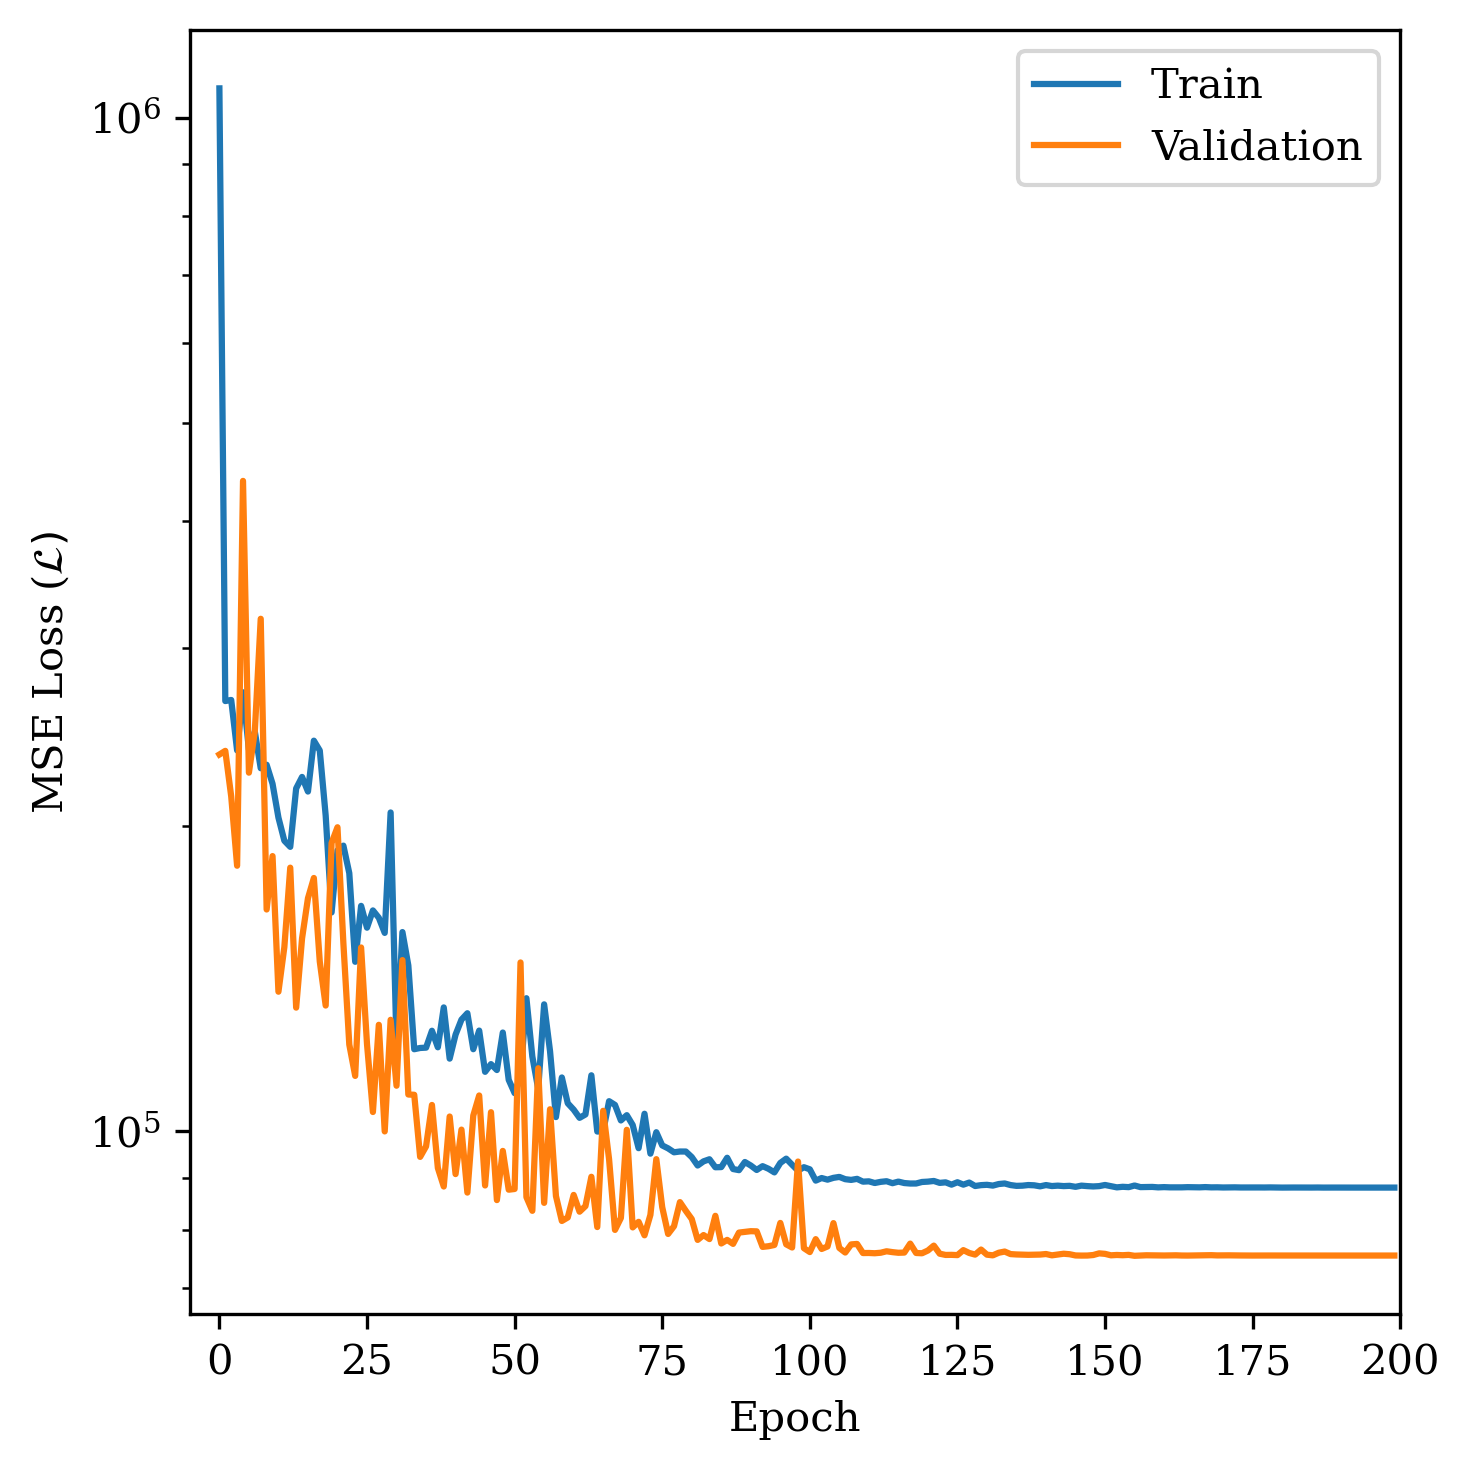

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# 1) Epoch vs R^2
plt.figure(dpi=300, figsize=(5,5)) 

plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 10

plt.plot(np.array(train_losses), label='Train')
plt.plot(np.array(test_losses), label='Validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel(r'MSE Loss ($\mathcal{L})$')
plt.yscale("log") 
plt.xlim(-5,epoch_num)
plt.tight_layout() 

# Save model

In [13]:
best_model_path = f'{args.save_model_dir}/epoch_{args.epoch_num}.pt'  
torch.save(best_state_dict, best_model_path)

# Evaluation

Test R2 for E: 0.9200340509414673


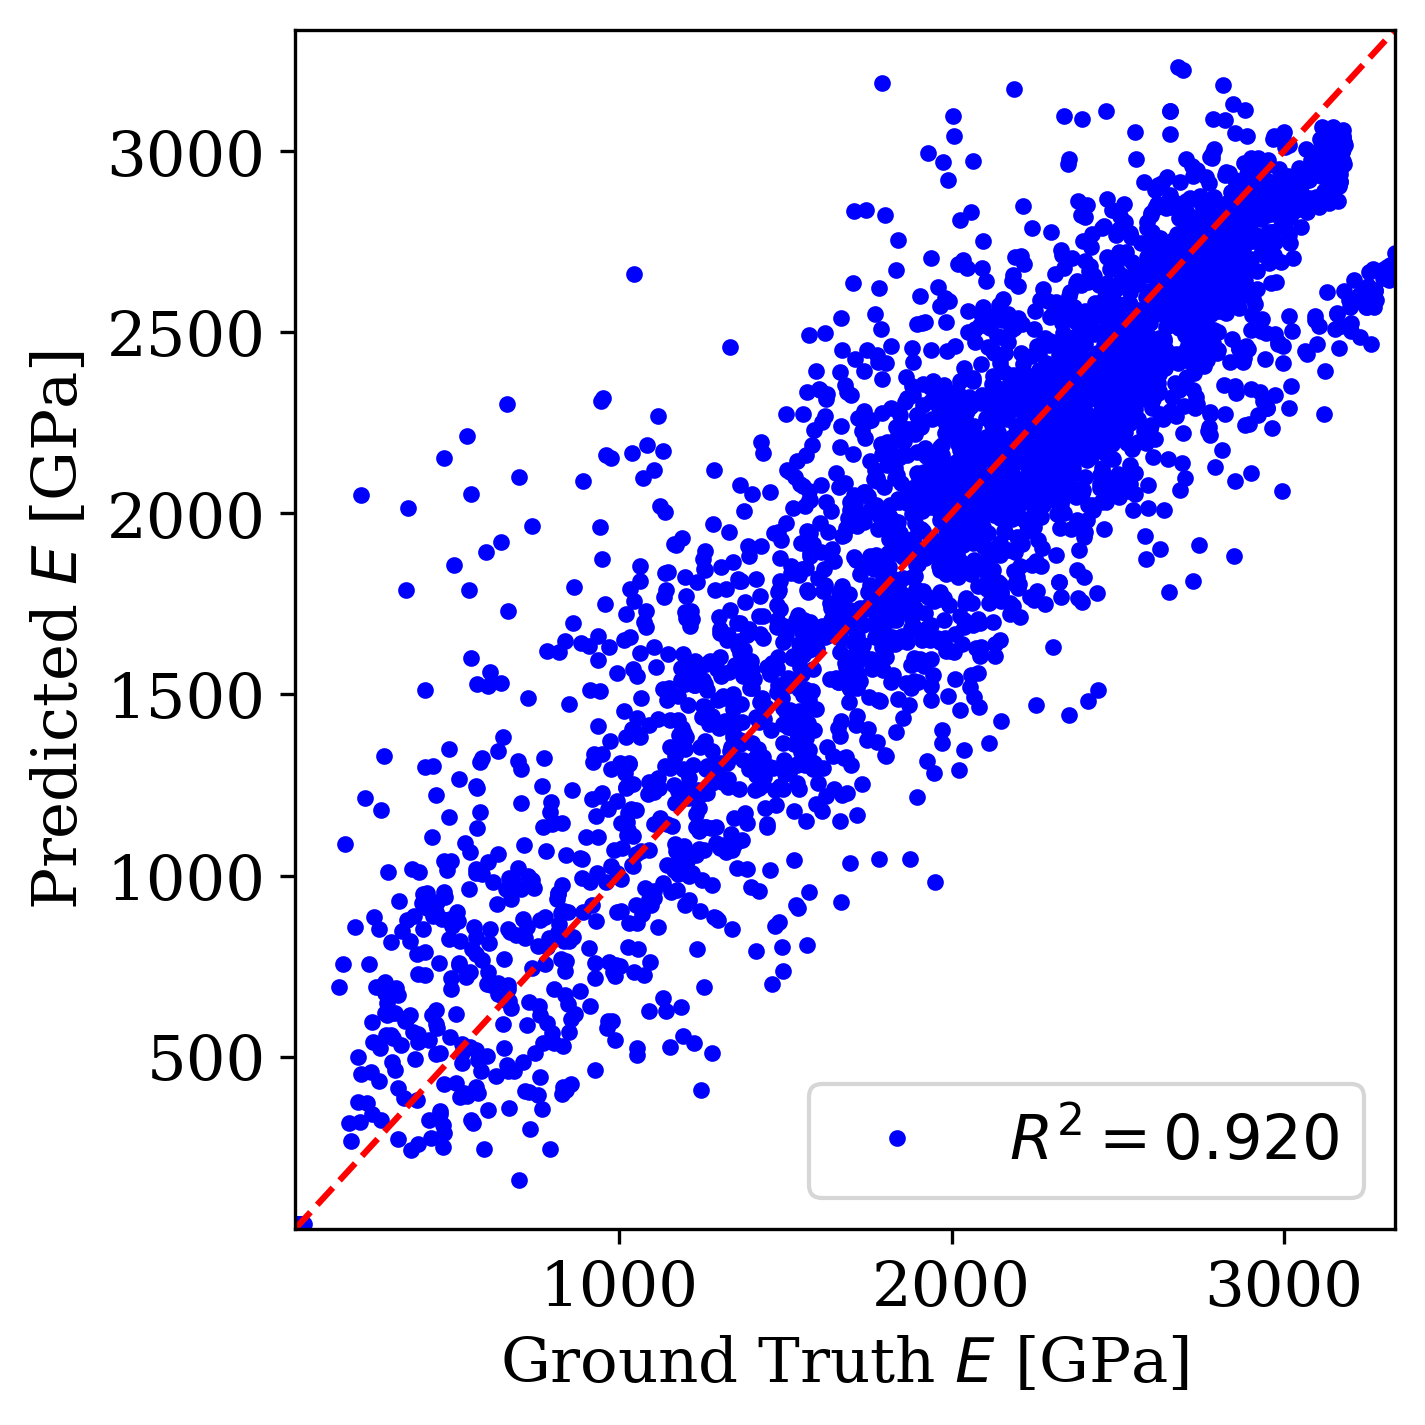

In [14]:
R2_K = evaluate_model(model, train_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.9275839924812317


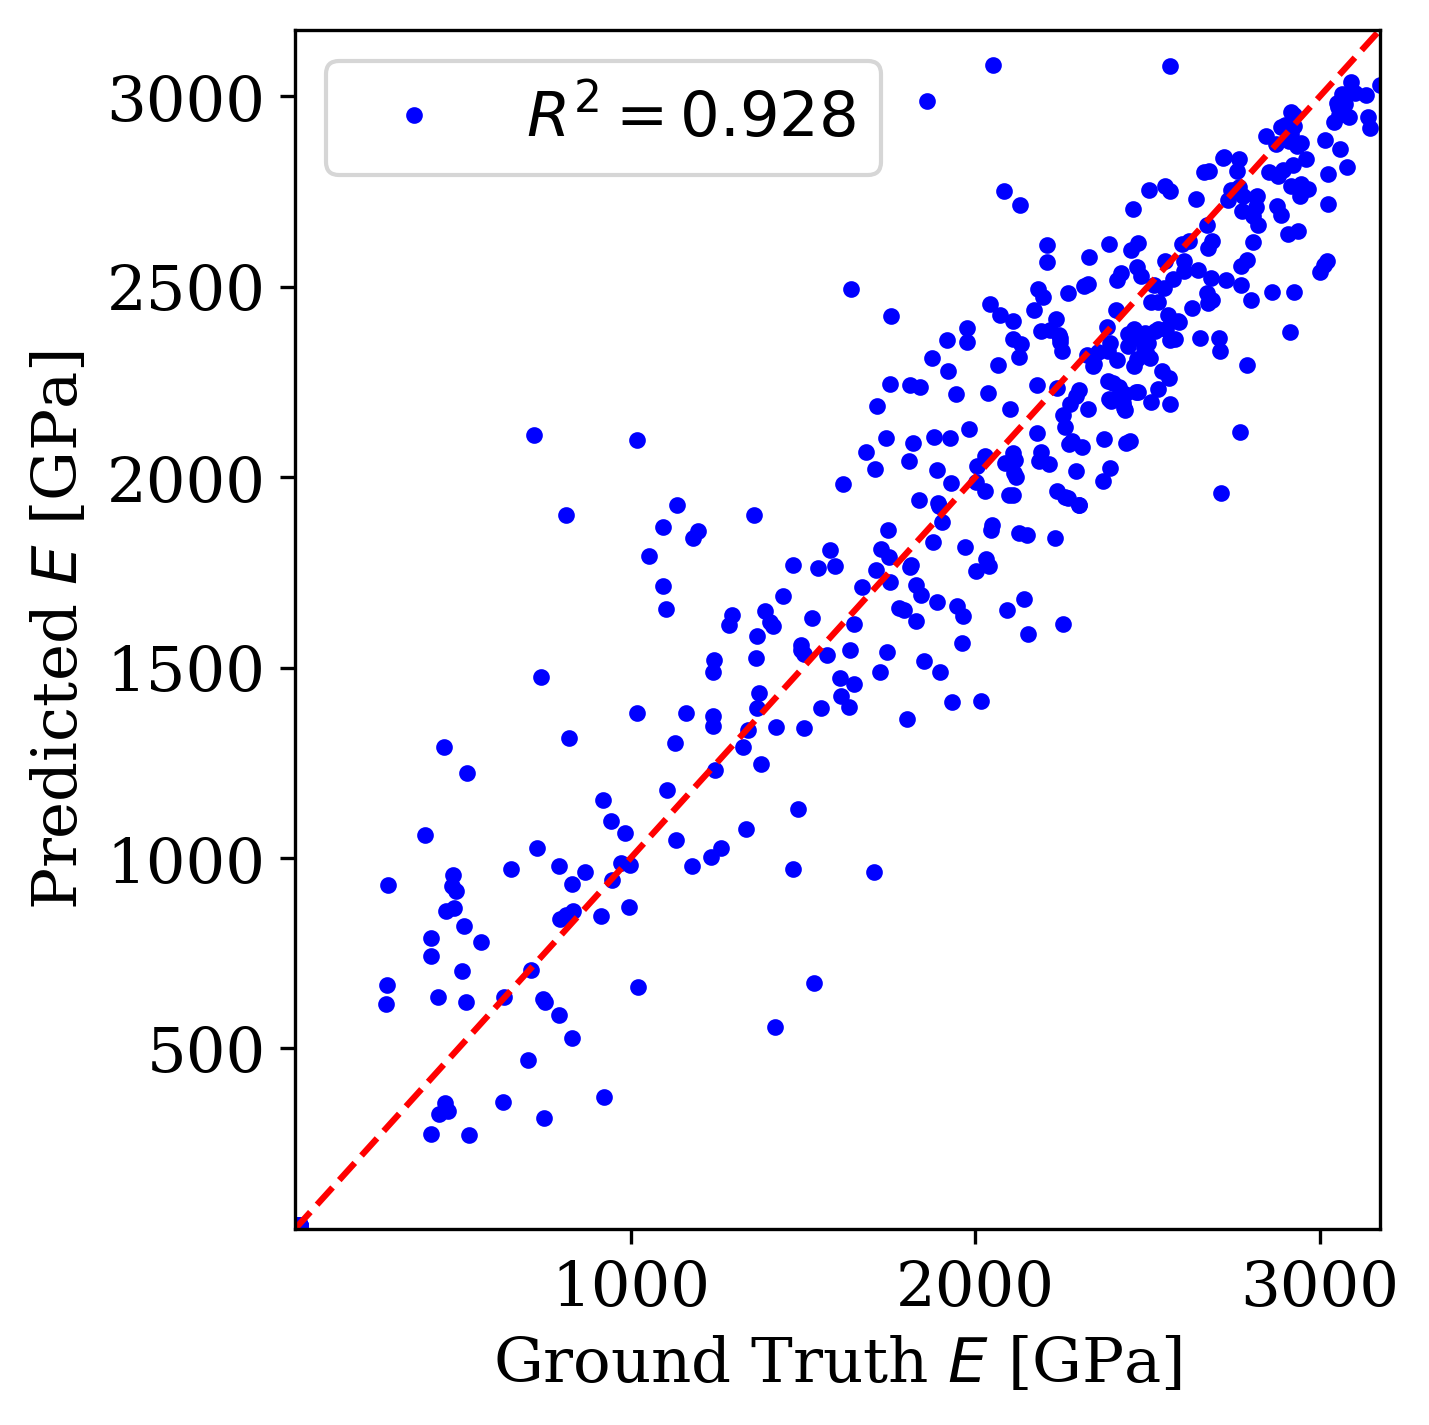

In [15]:
R2_K = evaluate_model(model, test_loader, device, args.cover_interval, overlap, args.save_model_dir)

Test R2 for E: 0.9353437423706055


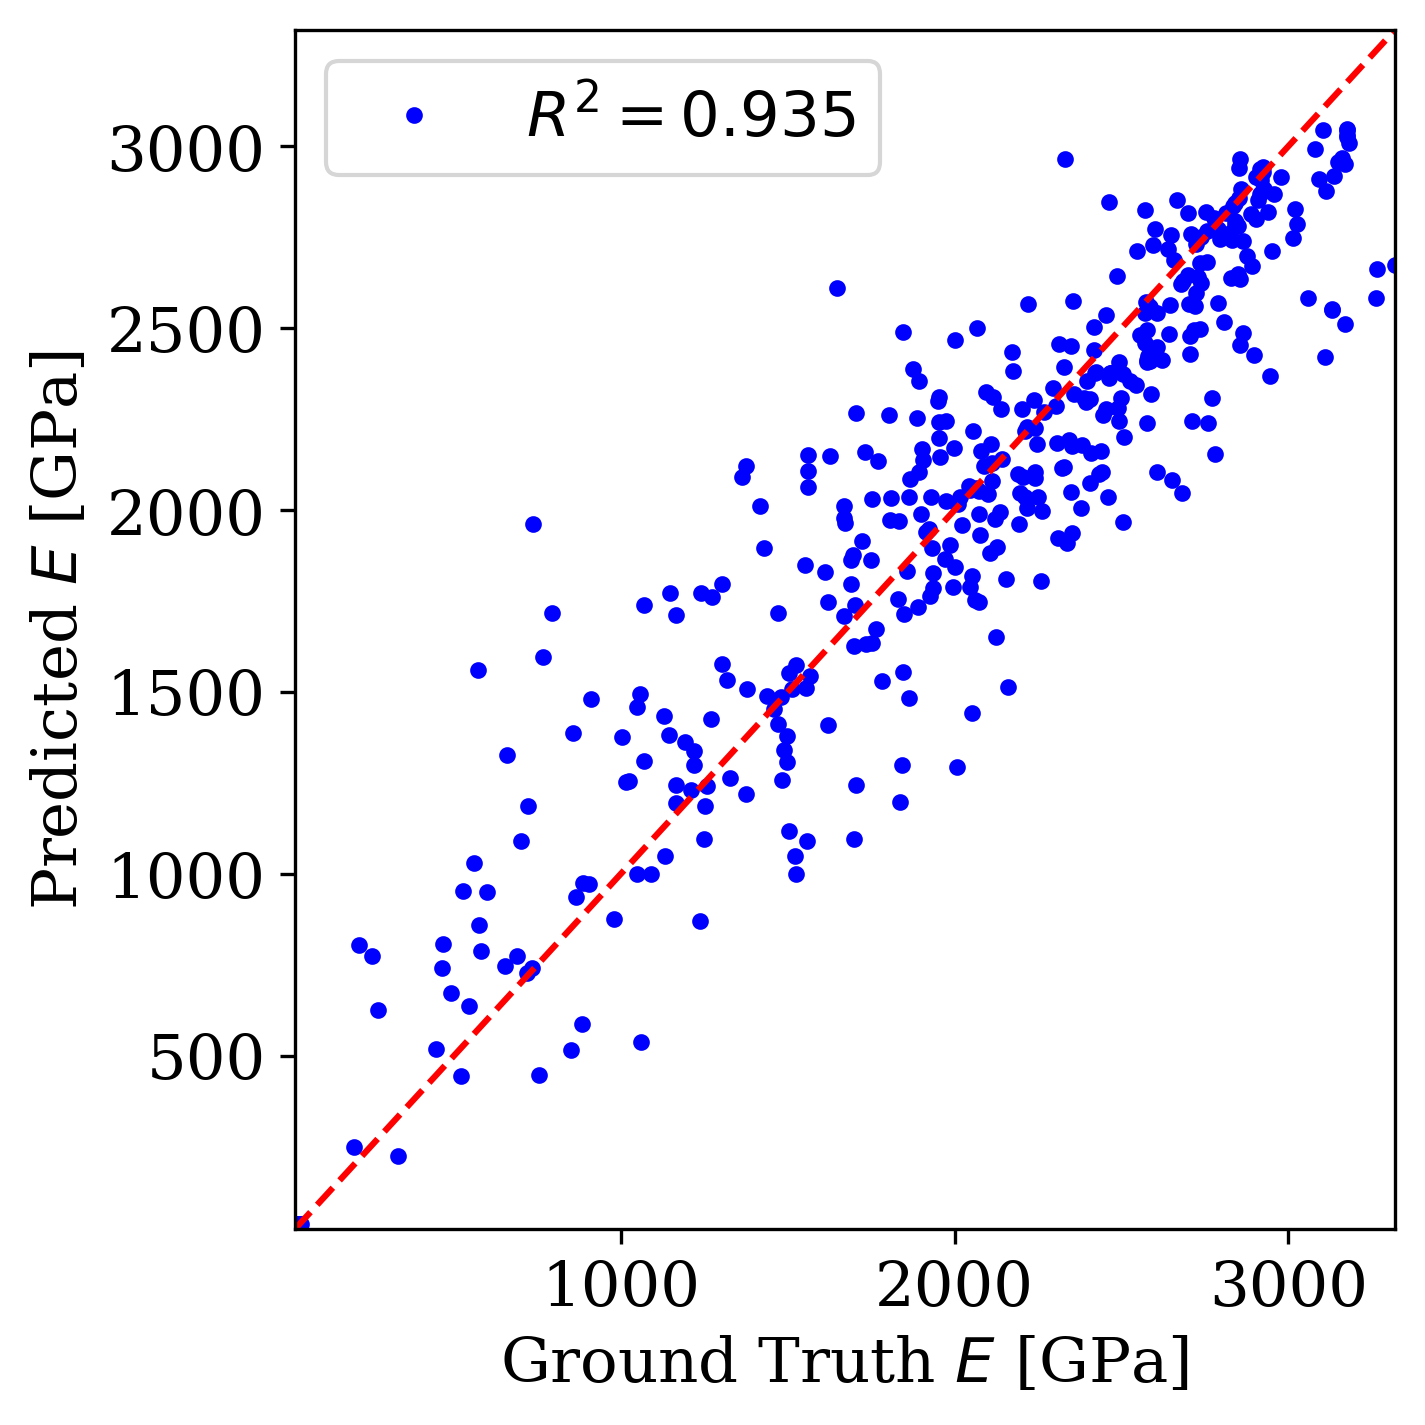

In [16]:
R2_K = evaluate_model(model, valid_loader, device, args.cover_interval, overlap, args.save_model_dir)